# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Is the pipeline functional?
  * Check of output at each stage of pipeline

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

bandwidth = 0.8
DBL_scaling = 0.5
subsample_dist = 'lognormal'
subsample_mean = 9.432
subsample_scale = 0.5
subsample_min = 10000
subsample_max = 30000

# Init

In [2]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome1147/validation


In [5]:
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_range_BD)
print 'Max BD: {}'.format(max_range_BD)

Min BD: 1.67323
Max BD: 1.7744


# Creating a community file

* 2 communities
  * control vs treatment

In [6]:
!SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

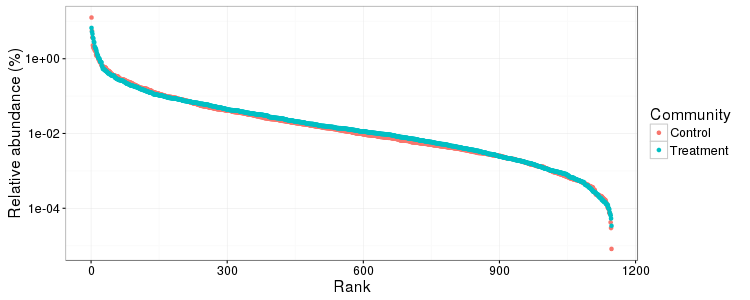

In [7]:
%%R -w 750 -h 300


tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)
tbl$library = ifelse(tbl$library == 1, 'Control', 'Treatment')

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    scale_color_discrete('Community') +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating gradient fractions

In [11]:
!SIPSim gradient_fractions \
    --BD_min $min_range_BD \
    --BD_max $max_range_BD \
    comm.txt \
    > fracs.txt    

## Plotting fractions

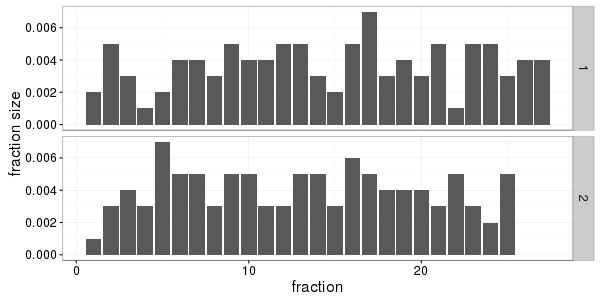

In [12]:
%%R -w 600 -h 300

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

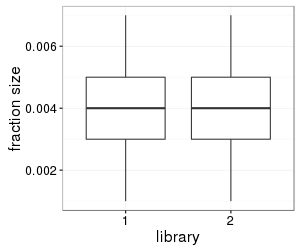

In [13]:
%%R -w 300 -h 250
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating fragments

In [14]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [15]:
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Number of amplicons per taxon

In [16]:
!grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 338|    o       
 320|    o       
 303|    o       
 285|    o       
 268|    o       
 250|    o       
 232|   oo       
 215|   oo       
 197|   oo       
 180|   oo       
 162|   oo o     
 144|   oo o     
 127|  ooo o     
 109|  ooo o     
  92|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1147     |
|    min value: 0.000000     |
|      mean : 3.823888       |
|    max value: 15.000000    |
------------------------------


In [17]:
!printf "Number of taxa with >=1 amplicon: "
!grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1102


# Converting fragments to kde object

In [18]:
!SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [19]:
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [20]:
%%R 
# loading
df = read.delim('ampFrags_kde_info.txt', sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

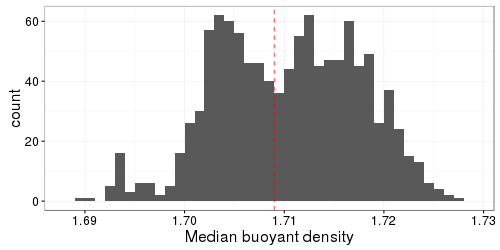

In [21]:
%%R -w 500 -h 250
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Adding diffusion

In [22]:
!SIPSim diffusion \
    --bw $bandwidth \
    --np 24 \
    ampFrags_kde.pkl \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding 'smearing'

* DBL = diffusive boundary layer

In [62]:
!SIPSim DBL \
    --comm comm.txt \
    --commx $DBL_scaling \
    --np 24 \
    -o ampFrags_kde_dif_DBL.pkl \
    ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!tail -n 5 ampFrags_kde_dif_DBL.log

Processing: Kosakonia_sacchari_SP1
Processing: Gluconobacter_oxydans_621H
Processing: Nocardia_farcinica_IFM_10152
Processing: Campylobacter_ureolyticus_RIGS_9880
Processing: Dyadobacter_fermentans_DSM_18053


## Comparing DBL+diffusion to diffusion

In [24]:
# none
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [25]:
%%R 

inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'Discrete BD'
df.raw = df.raw %>%
    filter(KDE_ID == 1)

inFile = 'ampFrags_kde_dif_info.txt'
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'Gaussian BD'

inFile = 'ampFrags_kde_dif_DBL_info.txt'
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'Gaussian BD +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID      min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1 1.706611     1.707293
2      1 Sorangium_cellulosum_So0157-2      1 1.713215     1.717143
3      1       Bacillus_subtilis_QB928      1 1.701117     1.703727
  percentile_25     mean   median percentile_75 percentile_95      max
1      1.708210 1.709684 1.709798      1.710688      1.712764 1.717466
2      1.720365 1.723498 1.724164      1.726866      1.728058 1.730404
3      1.706410 1.708337 1.708355      1.711045      1.711721 1.714139
        stdev       stage
1 0.001643647 Discrete BD
2 0.003666338 Discrete BD
3 0.002666531 Discrete BD


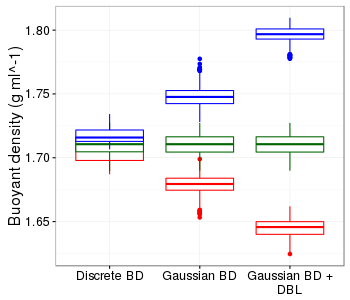

In [26]:
%%R -w 350 -h 300

df$stage = factor(df$stage, levels=c('Discrete BD', 'Gaussian BD', 'Gaussian BD +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    #scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

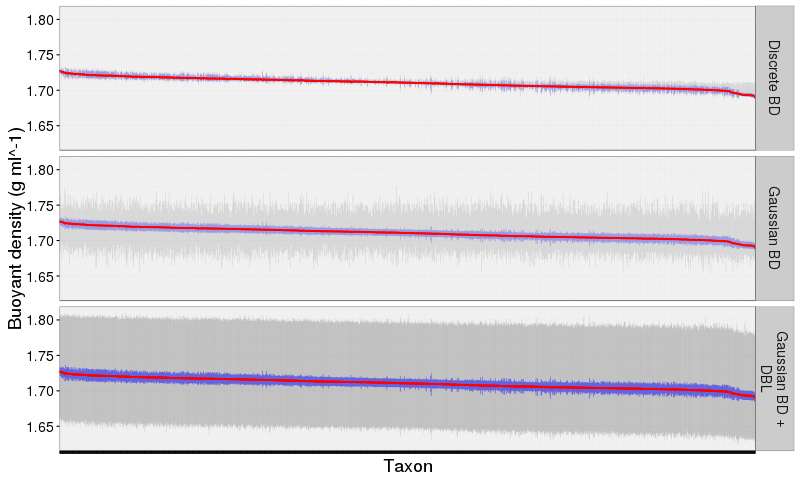

In [27]:
%%R -w 800
# plotting min-median-max for each taxon
df = df %>%
    group_by(taxon_ID) %>%
    mutate(max_median = max(median)) %>%
    ungroup() %>%
    filter(! is.na(median))

df$taxon_ID = reorder(df$taxon_ID, -df$max_median)

ggplot(df, aes(taxon_ID, median)) +    
    geom_linerange(aes(ymin=min, ymax=max), size=0.3, alpha=0.1) +
    geom_linerange(aes(ymin=percentile_5, ymax=percentile_95), size=0.3, alpha=0.3, color='blue') + 
    geom_point(size=0.3, color='red') +
    facet_grid(stage ~ .) +
    labs(x='Taxon', y = 'Buoyant density (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.text.x = element_blank()
    )

# Making an incorp config file

* 10% of taxa with 100% atom excess 13C

In [28]:
!SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config
    
# checking output
!head PT10_PI100.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            


# Adding isotope incorporation to BD distribution

In [29]:
!SIPSim isotope_incorp \
    --comm comm.txt \
    --np 24 \
    --shift ampFrags_BD-shift.txt \
    -o ampFrags_kde_dif_DBL_incorp.pkl \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking log
!tail -n 5 ampFrags_kde_dif_DBL_incorp.log

Processing: Gluconobacter_oxydans_621H
Processing: Nocardia_farcinica_IFM_10152
Processing: Chlorobium_phaeobacteroides_BS1
Processing: Dyadobacter_fermentans_DSM_18053
File written: ampFrags_BD-shift.txt


# Plotting stats on BD shift from isotope incorporation

In [30]:
%%R
inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

    library incorporator n_incorps n_incorps/sum(n_incorps)
1 treatment        FALSE       993               0.90108893
2 treatment         TRUE       109               0.09891107


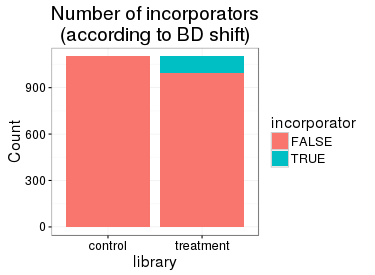

In [31]:
%%R -h 275 -w 375

inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

df.s = df %>% 
    mutate(incorporator = ifelse(min > 0.001, TRUE, FALSE),
           incorporator = ifelse(is.na(incorporator), 'NA', incorporator),
           library = ifelse(library == '1', 'control', 'treatment')) %>%
    group_by(library, incorporator) %>%
    summarize(n_incorps = n())

# summary of number of incorporators
df.s %>%
    filter(library == 'treatment') %>%
    mutate(n_incorps / sum(n_incorps)) %>% 
    as.data.frame %>% print

# plotting
ggplot(df.s, aes(library, n_incorps, fill=incorporator)) +
    geom_bar(stat='identity') +
    labs(y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Simulating an OTU table

In [32]:
!SIPSim OTU_table \
    --abs 1e9 \
    --np 20 \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!tail -n 5 OTU_n2_abs1e9.log 

   taxon abs-abundance:  13768157
  Processing taxon: "Bifidobacterium_kashiwanohense_JCM_15439_DSM_21854"
   taxon abs-abundance:  12560673
  Processing taxon: "Candidatus_Liberibacter_americanus_str_Sao_Paulo"
   taxon abs-abundance:  12235267


## Plotting taxon abundances

In [33]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

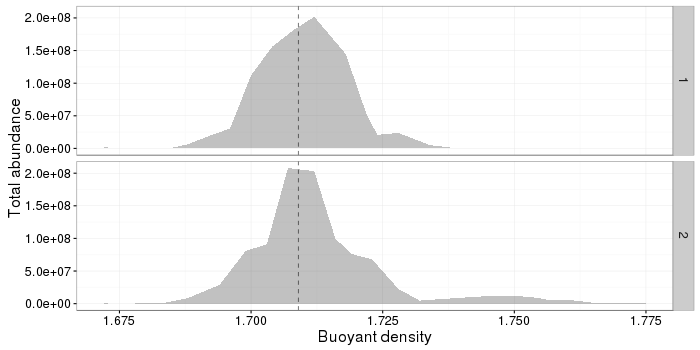

In [34]:
%%R -w 700 -h 350
# plotting absolute abundances

# loading file
df = read.delim('OTU_n2_abs1e9.txt', sep='\t') 

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

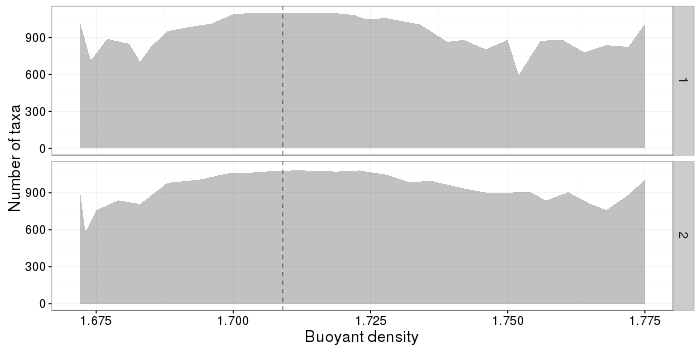

In [35]:
%%R -w 700 -h 350
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

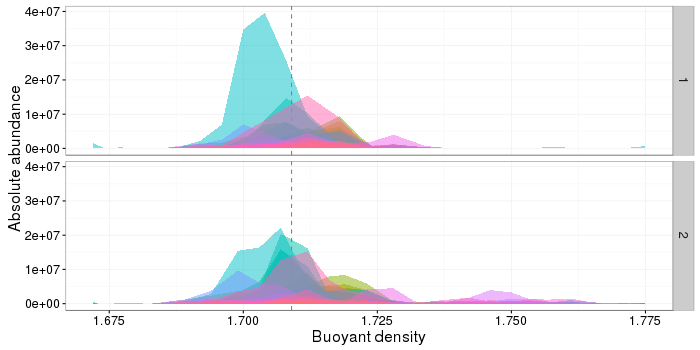

In [36]:
%%R -w 700 -h 350
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

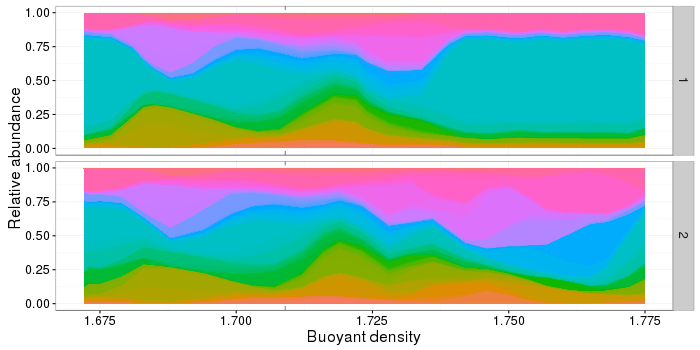

In [37]:
%%R -w 700 -h 350
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Simulating PCR bias

In [38]:
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

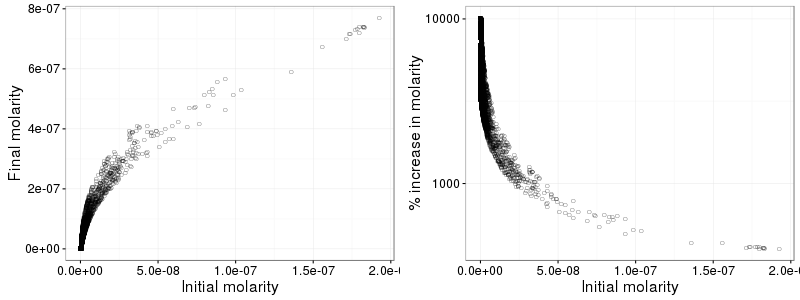

In [39]:
%%R -w 800 -h 300
# loading file
F = 'OTU_n2_abs1e9_PCR.txt'
df.SIM = read.delim(F, sep='\t') %>%
    mutate(molarity_increase = final_molarity / init_molarity * 100)

p1 = ggplot(df.SIM, aes(init_molarity, final_molarity)) +
    geom_point(shape='O', alpha=0.5) +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(init_molarity, molarity_increase)) +
    geom_point(shape='O', alpha=0.5) +
    scale_y_log10() +
    labs(x='Initial molarity', y='% increase in molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=2)

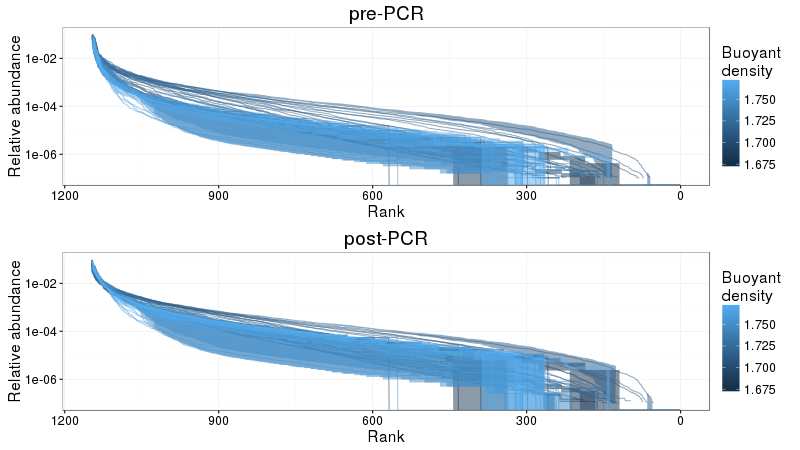

In [40]:
%%R -w 800 -h 450
# plotting rank abundances

df.SIM = df.SIM %>%
    group_by(library, fraction) %>%
    mutate(rel_init_molarity = init_molarity / sum(init_molarity),
           rel_final_molarity = final_molarity / sum(final_molarity),
           init_molarity_rank = row_number(rel_init_molarity),
           final_molarity_rank = row_number(rel_final_molarity)) %>%
    ungroup() 
    

p1 = ggplot(df.SIM, aes(init_molarity_rank, rel_init_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='pre-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(final_molarity_rank, rel_final_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='post-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


grid.arrange(p1, p2, ncol=1)

#### Notes

* The PCR raises the relative abundances most for low-abundance taxa
* Results in a more even rank-abundance distribution

In [41]:
# PCR w/out --debug
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_PCR.txt

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [42]:
!SIPSim OTU_subsample \
    --dist $subsample_dist \
    --dist_params mean:$subsample_mean,sigma:$subsample_scale \
    --min_size $subsample_min \
    --max_size $subsample_max \
    OTU_n2_abs1e9_PCR.txt \
    > OTU_n2_abs1e9_PCR_subNorm.txt

### Plotting seq count distribution

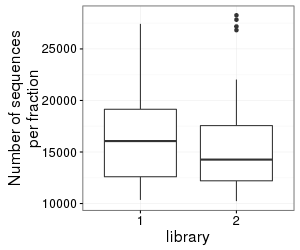

In [43]:
%%R -w 300 -h 250

df = read.csv('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    labs(y='Number of sequences\nper fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions (paper figure)

In [44]:
%%R 

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

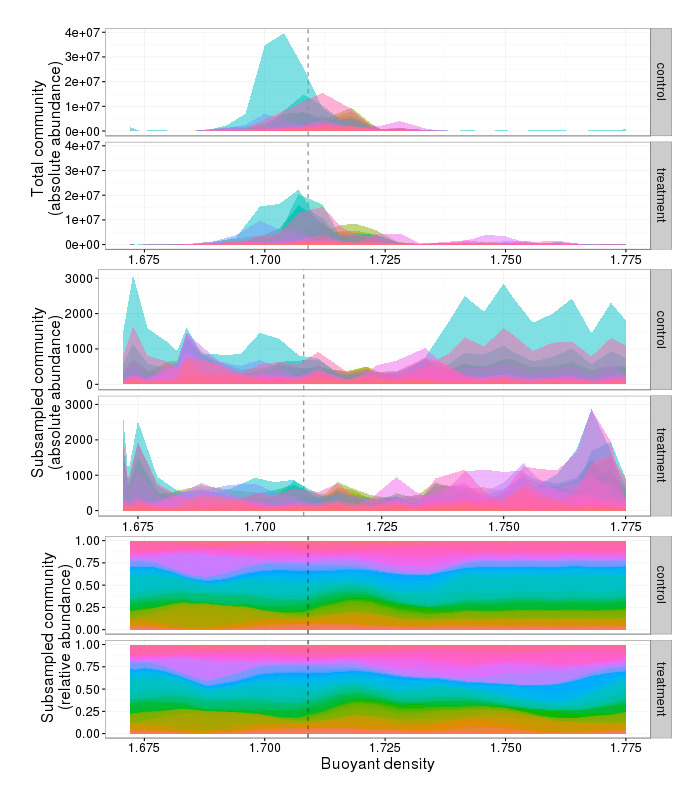

In [45]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

In [46]:
%%R -i figureDir 
# saving figure

outFile = file.path(figureDir, 'abundDist_example.pdf')

pdf(outFile, width=10.5, height=12)
grid.arrange(p1, p2, p3, ncol=1)
dev.off()

png 
  2 


# Making a wide OTU table

In [47]:
!SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [48]:
!SIPSim OTU_sampleData \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_meta.txt

# Community analysis

## Phyloseq

In [49]:
# making phyloseq object from OTU table
!SIPSimR phyloseq_make \
    OTU_n2_abs1e9_PCR_subNorm_w.txt \
    -s OTU_n2_abs1e9_PCR_subNorm_meta.txt \
    > OTU_n2_abs1e9_PCR_subNorm.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf    

## filtering phyloseq object to just taxa/samples of interest (eg., BD-min/max)
!SIPSimR phyloseq_edit \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_PCR_subNorm_filt.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf
    
# making png figures
!convert OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png
!convert OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.09659953 
Run 1 stress 0.1540416 
Run 2 stress 0.09659953 
... procrustes: rmse 7.350659e-06  max resid 2.994669e-05 
*** Solution reached
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
pre-filter: number of samples:56
pre-filter: number of taxa:1147
post-filt

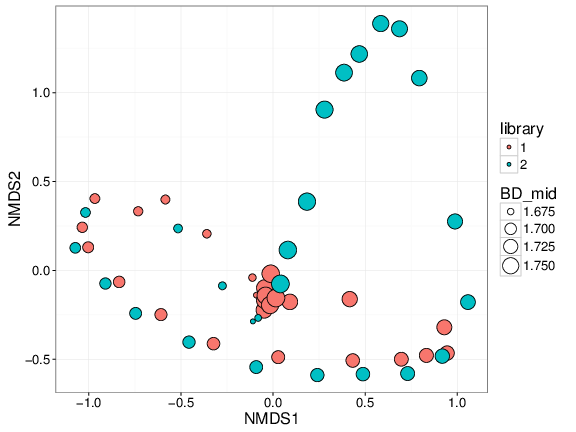

In [50]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png') 

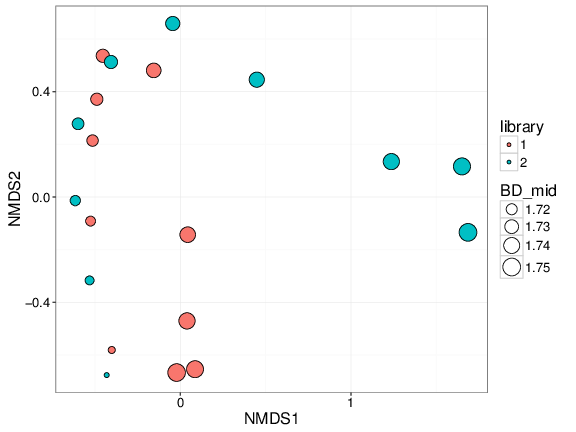

In [51]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png')

## DESeq2

In [52]:
## DESeq2
!SIPSimR phyloseq_DESeq2 \
    --log2 0.25 \
    --hypo greater \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_DESeq2
    
## Confusion matrix
!SIPSimR DESeq2_confuseMtx \
    --padj 0.1 \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_DESeq2

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx
File written: DESeq2-cMtx_data.txt
File written: DESeq2-cMtx_table.txt
File written: DESeq2-cMtx_overall.txt
File written: DESeq2-cMtx_byClass.txt


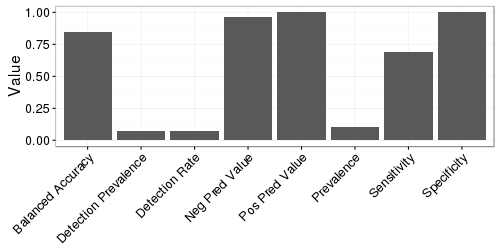

In [53]:
%%R -w 500 -h 250

byClass = read.delim('DESeq2-cMtx_byClass.txt', sep='\t') %>%
    filter(library == 2) 

ggplot(byClass, aes(variables, values)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

## Plotting results of DESeq2

In [54]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [55]:
%%R 

df = read.delim('DESeq2-cMtx_data.txt', sep='\t')

df = df %>%
    filter(! is.na(log2FoldChange), library == 2) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  library                          taxon   min   q25  mean median   q75   max
1       2 Acaryochloris_marina_MBIC11017 0.036 0.036 0.036  0.036 0.036 0.036
2       2 Acetobacterium_woodii_DSM_1030 0.000 0.000 0.000  0.000 0.000 0.000
3       2 Achromobacter_xylosoxidans_C54 0.000 0.000 0.000  0.000 0.000 0.000
    baseMean log2FoldChange     lfcSE     stat       pvalue         padj
1 43.2226315     5.98131498 1.3531650 4.235489 1.140276e-05 0.0004372959
2  1.9757496    -1.86219129 1.0325869 0.000000 9.795989e-01 0.9999973089
3  0.4973088     0.06925919 0.9852681 0.000000 5.727749e-01 0.9999973089
             p      padj.BH incorp.known incorp.pred           cls
1 1.140276e-05 0.0004372959         TRUE        TRUE True positive
2 9.795989e-01 0.9999973089        FALSE       FALSE True negative
3 5.727749e-01 0.9999973089        FALSE       FALSE True negative


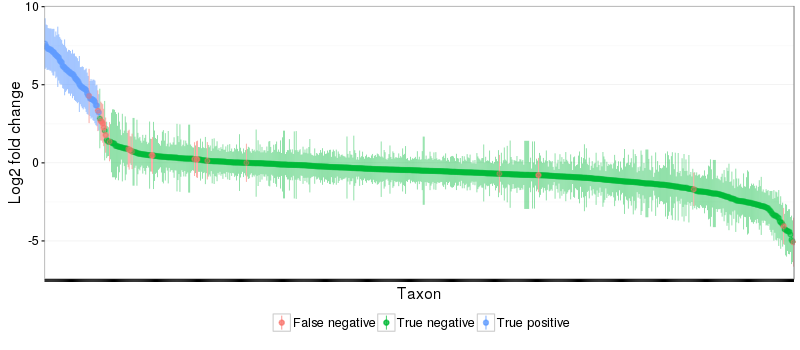

In [56]:
%%R -w 800 -h 350

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, 
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.4, alpha=0.5) +
    geom_pointrange(data=df.TP, size=0.4, alpha=0.3) +
    geom_pointrange(data=df.FP, size=0.4, alpha=0.3) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )

In [57]:
%%R -i figureDir

outFile = paste(c(figureDir, 'l2fc_example.pdf'), collapse='/')
ggsave(outFile, width=10, height=4)

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75
* Lines indicate standard errors.

# sensitivity ~ pre-frac relative_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [58]:
%%R
df.ds = read.delim('DESeq2-cMtx_data.txt', sep='\t') 
df.comm = read.delim('comm.txt', sep='\t')

df.j = inner_join(df.ds, df.comm, c('taxon' = 'taxon_name',
                                    'library' = 'library'))

df.ds = df.comm = NULL
df.j %>% head(n=3)

  library                          taxon   min   q25  mean median   q75   max
1       2 Acaryochloris_marina_MBIC11017 0.036 0.036 0.036  0.036 0.036 0.036
2       2 Acetobacterium_woodii_DSM_1030 0.000 0.000 0.000  0.000 0.000 0.000
3       2   Acholeplasma_laidlawii_PG-8A 0.000 0.000 0.000  0.000 0.000 0.000
  baseMean log2FoldChange    lfcSE     stat       pvalue         padj
1 43.22263       5.981315 1.353165 4.235489 1.140276e-05 0.0004372959
2  1.97575      -1.862191 1.032587 0.000000 9.795989e-01 0.9999973089
3  0.00000             NA       NA       NA           NA           NA
             p      padj.BH incorp.known incorp.pred rel_abund_perc rank
1 1.140276e-05 0.0004372959         TRUE        TRUE     0.02136093  448
2 9.795989e-01 0.9999973089        FALSE       FALSE     0.08158691  195
3           NA           NA        FALSE          NA     0.00191449  941


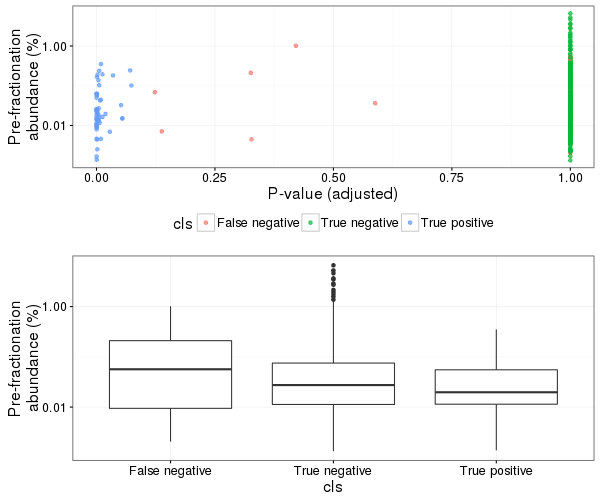

In [59]:
%%R -h 500 -w 600

df.j.f = df.j %>%
    filter(! is.na(log2FoldChange),
           library == 2) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) 

y.lab = 'Pre-fractionation\nabundance (%)'
p1 = ggplot(df.j.f, aes(padj, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='P-value (adjusted)', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )

p2 = ggplot(df.j.f, aes(cls, rel_abund_perc)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=1)

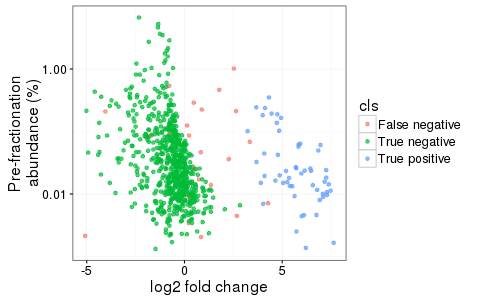

In [60]:
%%R -h 300
# plotting
ggplot(df.j.f, aes(log2FoldChange, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='log2 fold change', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


# sensitivity ~ fragment buoyant density

* **Enrichment of TP for incorporators with certain G+C fragments?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

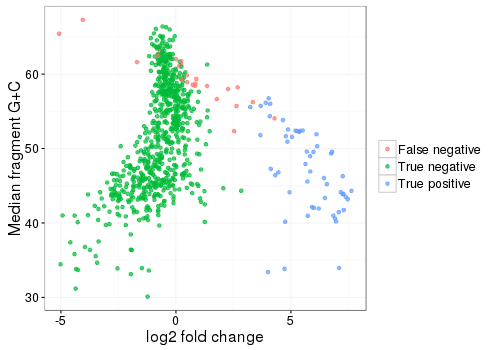

In [61]:
%%R -w 500 -h 350

# loading tables
inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t')
df.raw = df.raw %>%
    filter(KDE_ID == 1) %>%
    mutate(lib_ID = 2)

df.ds = read.delim('DESeq2-cMtx_data.txt', sep='\t') 

# joining tables
df.j = inner_join(df.ds, df.raw, c('taxon' = 'taxon_ID',
                                    'library' = 'lib_ID'))
df.raw = df.ds = NULL


# formatting
BD2GC = function(BD){
    GC = (BD - 1.66) / 0.098
    return(GC * 100)
}
df.j.f = df.j %>%
    filter(! is.na(log2FoldChange),
           library == 2) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known),
           median.GC = sapply(median.y, BD2GC))



# plotting
ggplot(df.j.f, aes(log2FoldChange, median.GC, color=cls)) +
    geom_point(alpha=0.7) +
    scale_color_discrete('') +
    labs(x='log2 fold change', y='Median fragment G+C') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

***

# --OLD--

### biserial correlation

In [206]:
%%R
library(ltm)

levs = c('True positive', 'False negative')

df.j.f %>%
    mutate(cls = factor(cls, levels=levs)) %>%
    group_by(library) %>%
    summarize(biserial_cor = biserial.cor(mean_rel_abund, cls))

Source: local data frame [2 x 2]

  library biserial_cor
    (int)        (dbl)
1       1   -0.2789406
2       2    0.3426538


### t-test

In [207]:
%%R
t.test(mean_rel_abund ~ cls, data=df.j.f)


	Welch Two Sample t-test

data:  mean_rel_abund by cls
t = -2.9055, df = 191.99, p-value = 0.004097
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0033042348 -0.0006320861
sample estimates:
mean in group False negative  mean in group True positive 
                 0.001378397                  0.003346558 



# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [211]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
df.otu = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')
#df.otu = read.delim('OTU_n2_abs1e9.txt', sep='\t')

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))

# edit
lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.j = mutate(df.j, library = plyr::revalue(as.character(library), lib.reval))

df.j %>% head(n=3)

    library    fraction                          taxon BD_min BD_mid BD_max
1   control  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
2 treatment  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
3   control 1.660-1.663 Acaryochloris_marina_MBIC11017   1.66  1.661  1.663
  count   rel_abund lib1 lib2 BD_shift baseMean log2FoldChange     lfcSE stat
1    51 0.001646223   NA    2        0 3.751202     -0.5731145 0.9246022    0
2    26 0.001374425   NA    2        0 3.751202     -0.5731145 0.9246022    0
3    16 0.001058271   NA    2        0 3.751202     -0.5731145 0.9246022    0
     pvalue      padj         p   padj.BH incorp.known incorp.pred
1 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE
2 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE
3 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE


In [212]:
%%R
# DESeq2 params
BD.win.min = 1.71
BD.win.max = 1.75

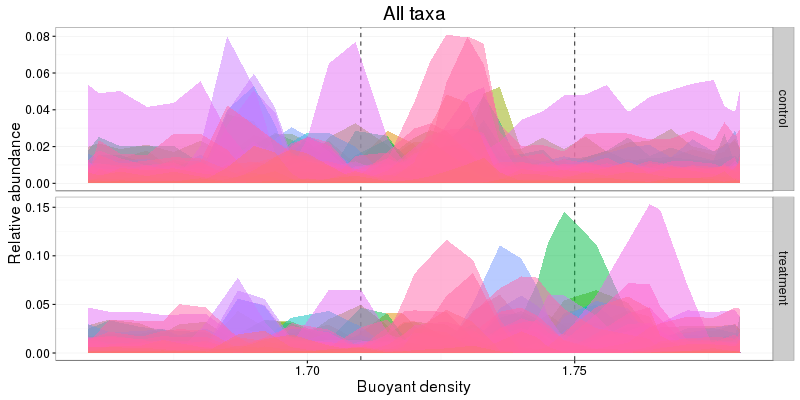

In [213]:
%%R -w 800 -h 400
# plotting relative abundances: all
## plot
p = ggplot(df.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='All taxa') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p

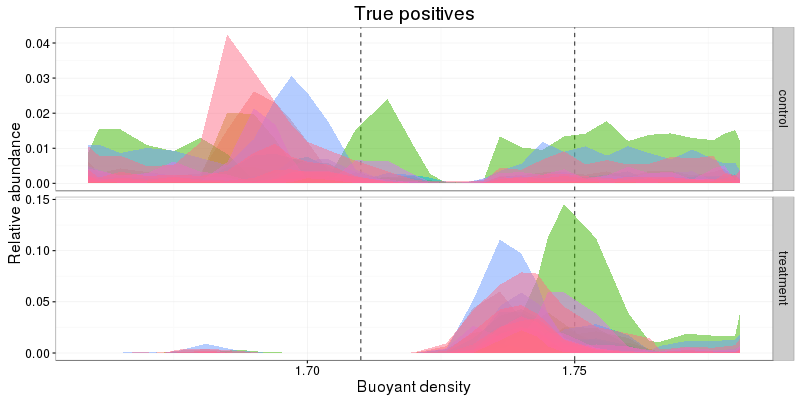

In [214]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.TP = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(df.j.TP, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='True positives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p1

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

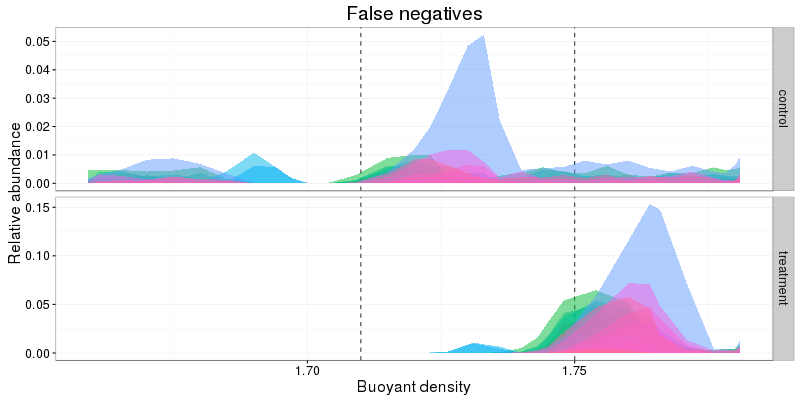

In [215]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.FN = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(df.j.FN, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='False negatives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p2

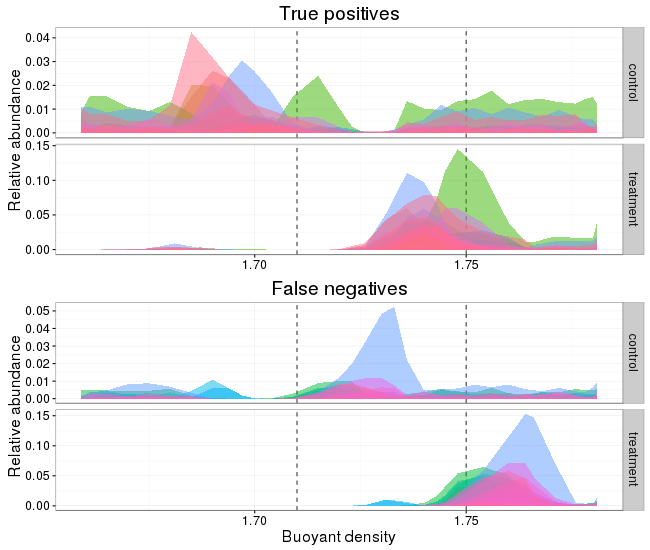

In [216]:
%%R -i figureDir -h 550 -w 650

outFile = paste(c(figureDir, 'abundDist_TP-FN_example.pdf'), collapse='/')

p1.e = p1 + theme(axis.title.x = element_blank())

pdf(outFile, width=13, height=11)
grid.arrange(p1.e, p2, ncol=1)
dev.off()

grid.arrange(p1.e, p2, ncol=1)

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

## Indy taxa BD shift plots

In [217]:
%%R
# checking on number of incorporators
df.j %>% filter(BD_shift > 0.05) %>% distinct(taxon) %>% nrow %>% print
df.j %>% filter(incorp.known == TRUE) %>% distinct(taxon) %>% nrow %>% print

[1] 97
[1] 97


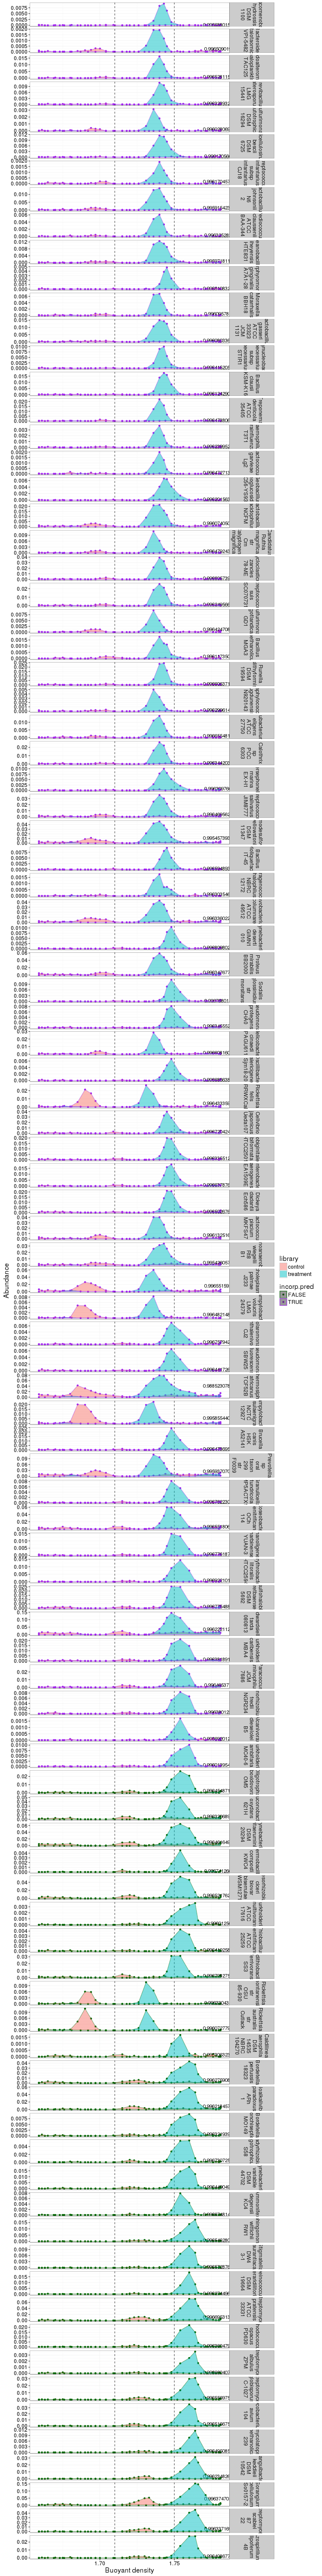

In [218]:
%%R -w 750 -h 6000
# plotting relative abundances

df.j.f = df.j %>%
    filter(incorp.known == TRUE) %>%
    mutate(taxon= gsub('_', '\n', taxon))
           
df.j.f$taxon = reorder(df.j.f$taxon, -df.j.f$log2FoldChange)

quant = function(x, p=0.95){
    x = x %>% as.numeric
    return(quantile(x, probs=c(0.9))[1] %>% as.numeric)
}

df.j.f.txt = df.j.f %>%
    group_by(taxon, BD_shift) %>%
    summarize(BD_mid = max(BD_mid),
              count = quant(count),
              rel_abund = quant(rel_abund)) %>%
    ungroup() 


## plot
p = ggplot(df.j.f, aes(BD_mid, rel_abund)) +
    geom_point(aes(color=incorp.pred)) +
    geom_text(data=df.j.f.txt, aes(label=BD_shift)) +
    scale_color_manual(values=c('darkgreen', 'purple')) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance') +
    facet_grid(taxon ~ ., scale='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )

p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5, aes(fill=library, color=incorp.pred))
p2